## Run me on colab 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rjlopez2/ADS_CAS_Bern_2020/blob/main/Projects/M1%20and%20M2/.ipynb_checkpoints/M1M2_cas_data_science_v2_agch-checkpoint.ipynb)


### **Import libraries**

In [96]:
import pandas as pd
!pip install wget # uncomment this igf you run it via colab
import os
from zipfile import ZipFile
import numpy as np
import wget
import requests
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 200)

# Part I 
# M1 project 

## On data aquisition, formating and cleaning

# 1. John Hopkins data collection and cleaning
### **Download the time series datasets on global Covid cases from the John Hpkins University**
The time series are organized in 3 different files from their Github repository:

 - one file retrieve information on the confirmed cases
 - one file retrieve information on the death cases
 - one file retrieve information on the recovered cases

Below we download the 3 datastes and store them locally in .csv format.

In [97]:
urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
       'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
       'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv']

path = os.getcwd() # get the current directory

for url in urls:
    filename = path + '/' + os.path.basename(url) # get the full path of the file
    if os.path.exists(filename):
        os.remove(filename) # if exist, remove it directly
    wget.download(url, out=filename) # download it to the specific path.
    
# IMPORTANT: if error loading files bacause link is down, don't run this code chunk and go to the next.
# It will read only the local data in the repo from the last time this script was run and updated

In [98]:
confirmed_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('time_series_covid19_recovered_global.csv')

### **We explore below the structure of the 3 datasets**

By looking at the shape of the 3 df, we observe that the recovered_df has different dimention than the two others.
Closer inspection revealed that 14 provinces from Canada were missed in the recovered_df.

In [99]:
# check size of the 3 datasets
print([confirmed_df.shape, deaths_df.shape, recovered_df.shape])


[(267, 270), (267, 270), (254, 270)]


In [100]:
confirmed_df[~confirmed_df['Province/State'].isin(recovered_df['Province/State'])][['Province/State', 'Country/Region']] # !!! 14 'Province/State'  no found in the recovered_df

,Province/State,Country/Region
39,Alberta,Canada
40,British Columbia,Canada
41,Diamond Princess,Canada
42,Grand Princess,Canada
43,Manitoba,Canada
44,New Brunswick,Canada
45,Newfoundland and Labrador,Canada
46,Northwest Territories,Canada
47,Nova Scotia,Canada
48,Ontario,Canada


Because of this inconsistency, we decided to exclude data from Canada for now.

In [101]:
recovered_df = recovered_df[recovered_df['Country/Region']!='Canada']
confirmed_df = confirmed_df[confirmed_df['Country/Region']!='Canada']
deaths_df = deaths_df[deaths_df['Country/Region']!='Canada']

In [102]:
# check size of the 3 datasets
print([confirmed_df.shape, deaths_df.shape, recovered_df.shape])


[(253, 270), (253, 270), (253, 270)]


We observed that the first 4 colums of each dataset have the same variables so we use them to merge all 3 datasets and we define the time variable with the rest of the colums

1. We create the vector for the time varibale
2. we transform the 3 dataframes to long format. 

In [103]:
recovered_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '10/4/20', '10/5/20', '10/6/20', '10/7/20', '10/8/20', '10/9/20',
       '10/10/20', '10/11/20', '10/12/20', '10/13/20'],
      dtype='object', length=270)

In [104]:
deaths_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '10/4/20', '10/5/20', '10/6/20', '10/7/20', '10/8/20', '10/9/20',
       '10/10/20', '10/11/20', '10/12/20', '10/13/20'],
      dtype='object', length=270)

In [105]:
confirmed_df.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '10/4/20', '10/5/20', '10/6/20', '10/7/20', '10/8/20', '10/9/20',
       '10/10/20', '10/11/20', '10/12/20', '10/13/20'],
      dtype='object', length=270)

In [106]:
dates = confirmed_df.columns[4:]

confirmed_df_long = confirmed_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Confirmed')

deaths_df_long = deaths_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Deaths')

recovered_df_long = recovered_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Recovered')

In [107]:
# check the size of each dataset in long format
print([confirmed_df_long.shape, deaths_df_long.shape, recovered_df_long.shape])

[(67298, 6), (67298, 6), (67298, 6)]


In [108]:
# check if the number of countries are the same in each subset
print(confirmed_df_long['Country/Region'].drop_duplicates().shape, 
      deaths_df_long['Country/Region'].drop_duplicates().shape, 
      recovered_df_long['Country/Region'].drop_duplicates().shape)
      

(188,) (188,) (188,)


In [175]:
confirmed_df_long

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0
...,...,...,...,...,...,...,...,...
67293,NaN,West Bank and Gaza,31.952200,35.233200,2020-10-13,45200,391,38841
67294,NaN,Western Sahara,24.215500,-12.885800,2020-10-13,10,1,8
67295,NaN,Yemen,15.552727,48.516388,2020-10-13,2053,596,1329
67296,NaN,Zambia,-13.133897,27.849332,2020-10-13,15587,345,14783


In [109]:
# Merge the 3 datasets 

confirmed_df_long["Deaths"] = deaths_df_long["Deaths"]
confirmed_df_long["Recovered"] = recovered_df_long['Recovered']
full_table = confirmed_df_long

In [110]:
full_table.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67298 entries, 0 to 67297
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  17822 non-null  object 
 1   Country/Region  67298 non-null  object 
 2   Lat             67298 non-null  float64
 3   Long            67298 non-null  float64
 4   Date            67298 non-null  object 
 5   Confirmed       67298 non-null  int64  
 6   Deaths          67298 non-null  int64  
 7   Recovered       67298 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 4.1+ MB


In [111]:
# trasnform from string to date the "Date" column
full_table['Date'] = pd.to_datetime(full_table['Date'])

### **Check and fix NaN in the full dataset**

In [112]:
full_table.isna().sum()

Province/State    49476
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64

### **Remove cruise ships data**
 #### We also observed that there is some of confirmed cases of Covid from the cruise ships (Grand Princess, Diamond Princess and MS Zaandam) that make it difficult to fit in in the Country category, so we excluded from our anaysis

In [113]:
# select the ships rows
ship_rows = full_table['Province/State'].str.contains('Grand Princess') | full_table['Province/State'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('MS Zaandam')

In [114]:
full_table = full_table[~(ship_rows)] # the '~' operator negate the selections

## **Add new colum for active cases**
Below we compute the active cases by substracting the number of death and recovered to the confirmed cases.

In [115]:
# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']
full_table

/Users/rubencito/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0,0
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0,0
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0
...,...,...,...,...,...,...,...,...,...
67293,NaN,West Bank and Gaza,31.952200,35.233200,2020-10-13,45200,391,38841,5968
67294,NaN,Western Sahara,24.215500,-12.885800,2020-10-13,10,1,8,1
67295,NaN,Yemen,15.552727,48.516388,2020-10-13,2053,596,1329,128
67296,NaN,Zambia,-13.133897,27.849332,2020-10-13,15587,345,14783,459


We agregate the data by Country and Date (by means of grouping) and calculate de sum of the cases

In [116]:
full_grouped = full_table.groupby(['Date', 'Country/Region'])[['Confirmed', 'Deaths', 'Recovered', 'Active']].sum().reset_index()

full_grouped

,Date,Country/Region,Confirmed,Deaths,Recovered,Active
0,2020-01-22,Afghanistan,0,0,0,0
1,2020-01-22,Albania,0,0,0,0
2,2020-01-22,Algeria,0,0,0,0
3,2020-01-22,Andorra,0,0,0,0
4,2020-01-22,Angola,0,0,0,0
...,...,...,...,...,...,...
49471,2020-10-13,West Bank and Gaza,45200,391,38841,5968
49472,2020-10-13,Western Sahara,10,1,8,1
49473,2020-10-13,Yemen,2053,596,1329,128
49474,2020-10-13,Zambia,15587,345,14783,459


## Add new column(s) for new cases / new deaths / new recovered

In [117]:
# new cases 
temp = full_grouped.groupby(['Country/Region', 'Date', ])['Confirmed', 'Deaths', 'Recovered']
temp = temp.sum().diff().reset_index()

mask = temp['Country/Region'] != temp['Country/Region'].shift(1)

temp.loc[mask, 'Confirmed'] = np.nan
temp.loc[mask, 'Deaths'] = np.nan
temp.loc[mask, 'Recovered'] = np.nan

# renaming columns
temp.columns = ['Country/Region', 'Date', 'New_cases', 'New_deaths', 'New_recovered']

# merging new values
full_grouped = pd.merge(full_grouped, temp, on=['Country/Region', 'Date'])# filling na with 0
full_grouped = full_grouped.fillna(0)

# fixing data types
cols = ['New_cases', 'New_deaths', 'New_recovered']
full_grouped[cols] = full_grouped[cols].astype('int')

# 
full_grouped['New_cases'] = full_grouped['New_cases'].apply(lambda x: 0 if x<0 else x)

/Users/rubencito/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [118]:
#rename the "Country/Region" variable
full_grouped.rename(columns = {'Country/Region' : 'Country_Region'}, inplace = True)


In [119]:
# compute the number of countries registered in the covide dataset
full_grouped['Country_Region'].unique().size

186

## **Extract metadata for Covid datasets**
We want to merge the covid dataset with other datasets by a comun variable, in our case is the Country. To make sure that the union of datasets are compatible, and since countries might be named disticntly  from each dataset source we use the country code as an standard varibale fro later merge. Now we asign to the Covid dataframe a new colum for the Country codes. To achieve this task we do the following steps: 
 - Load metadata from the Covid repository
 - Extract the information on Country code (here is the variable called 'iso3')

We also extract additional information on the population from each country. this will be used later for normalizing our variables.

In [120]:
covid_metadata_countries = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv",
                                      usecols = ['Country_Region', 'Province_State', 'iso3', 'Population'])


In [121]:
covid_metadata_countries.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4154 entries, 0 to 4153
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   iso3            4152 non-null   object 
 1   Province_State  3965 non-null   object 
 2   Country_Region  4154 non-null   object 
 3   Population      4013 non-null   float64
dtypes: float64(1), object(3)
memory usage: 129.9+ KB


### **Remove regional subset in hte metadata and only work at national level**

In [122]:
covid_metadata_countries = covid_metadata_countries[covid_metadata_countries['Province_State'].isna()].drop_duplicates()#.shape

### **Remove the cruise ships information from the metadata on country codes**

In [123]:
# select from columns 'Country_Region' the names 'Diamond Princess'and 'MS Zaandam'
ship_metadata = covid_metadata_countries['Country_Region'].str.contains('Diamond Princess') | covid_metadata_countries['Country_Region'].str.contains('MS Zaandam')
ship_metadata
covid_metadata_countries = covid_metadata_countries[~(ship_metadata)]

### **Summarize the population by country in the metadata dataframe**

In [124]:
#my_covid_variables = ['Confirmed', 'Deaths', 'Recovered', 'Active']
code_vars = ['Country_Region', 'iso3']

#full_table.groupby(['Date', 'Country/Region'])[my_covid_variables].sum().reset_index()
country_population = covid_metadata_countries.groupby(code_vars)['Population'].sum().reset_index()

In [125]:
country_population['Country_Region'].unique().shape

(187,)

In [127]:
# this is the number of countries registered in the Covid df
full_grouped['Country_Region'].unique().size

186

### **Merge country code with Covid datasets**

In [128]:
full_grouped_ccode = pd.merge(country_population, full_grouped, how = 'left')


In [129]:
full_grouped_ccode.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49477 entries, 0 to 49476
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Country_Region  49477 non-null  object        
 1   iso3            49477 non-null  object        
 2   Population      49477 non-null  float64       
 3   Date            49476 non-null  datetime64[ns]
 4   Confirmed       49476 non-null  float64       
 5   Deaths          49476 non-null  float64       
 6   Recovered       49476 non-null  float64       
 7   Active          49476 non-null  float64       
 8   New_cases       49476 non-null  float64       
 9   New_deaths      49476 non-null  float64       
 10  New_recovered   49476 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 4.5+ MB


In [130]:
full_grouped_ccode.rename(columns = {'iso3' : 'CountryCode'}, inplace = True)

In [131]:
# Check NaNs generated during the merge and remove them
full_grouped_ccode.isna().sum()

Country_Region    0
CountryCode       0
Population        0
Date              1
Confirmed         1
Deaths            1
Recovered         1
Active            1
New_cases         1
New_deaths        1
New_recovered     1
dtype: int64

In [132]:
full_grouped_ccode = full_grouped_ccode[~full_grouped_ccode['Date'].isna()]

# 2. Oxford Stringency index data collection, cleaning and merging

In [133]:
str_url = ["https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv"]

for url in str_url:
    filename = path + '/' + os.path.basename(url) # get the full path of the file
    if os.path.exists(filename):
        os.remove(filename) # if exist, remove it directly
    wget.download(url, out=filename) # download it to the specific path.
# IMPORTANT: if error loading files bacause link is down, don't run this code chunk and go to the next.
# It will read only the local data in the repo from the last time this script was run and updated

In [134]:
my_string_columns = ["Date", "CountryCode", "CountryName", "StringencyIndex", "RegionName", "RegionCode"] 
stringency_raw_dataset = pd.read_csv("OxCGRT_latest.csv", usecols = my_string_columns, low_memory=False)
stringency_raw_dataset.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69984 entries, 0 to 69983
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CountryName      69984 non-null  object 
 1   CountryCode      69984 non-null  object 
 2   RegionName       16128 non-null  object 
 3   RegionCode       16128 non-null  object 
 4   Date             69984 non-null  int64  
 5   StringencyIndex  66723 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 3.2+ MB


### **Selecting national data only ( exclude regional data) read documentation in this link why -> https://github.com/OxCGRT/covid-policy-tracker**
To take only the natinal data we followed instructions in the link above and take only rows where the variable RegionCoide is Null

In [135]:
stringe_natio_dataset = stringency_raw_dataset[stringency_raw_dataset.RegionCode.isnull()]


In [136]:
# remove columns with no needed information
stringe_natio_dataset = stringe_natio_dataset[my_string_columns[:4]]

Closer inspection revealed that the number of country codes from the Stringency dataset is less than the number of country codes in the Covid dataframe.


In [137]:
print([stringe_natio_dataset['CountryCode'].unique().size, 
       full_grouped_ccode['CountryCode'].unique().size])


[187, 186]


#### **The list below shows the Countries/region/dependencies which have not information regarding stringency index. Those countries (31) will be excluded form the analysis for the momment**

In [138]:
# finding What is not present in the stringency dataset
full_grouped_ccode[~full_grouped_ccode['CountryCode'].isin(stringe_natio_dataset['CountryCode'])][['CountryCode', 'Country_Region']].drop_duplicates()

,CountryCode,Country_Region
1330,ATG,Antigua and Barbuda
1862,ARM,Armenia
2926,BHS,Bahamas
14099,GNQ,Equatorial Guinea
17823,GRD,Grenada
18621,GNB,Guinea-Bissau
19419,VAT,Holy See
23941,XKS,Kosovo
26335,LIE,Liechtenstein
27931,MDV,Maldives


In [139]:
## We filtered out the countries above for joining with the covid dataset
full_grouped_ccode_filtered = full_grouped_ccode[full_grouped_ccode['CountryCode'].isin(stringe_natio_dataset['CountryCode'])]

In [140]:
full_grouped_ccode_filtered.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44422 entries, 0 to 49476
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Country_Region  44422 non-null  object        
 1   CountryCode     44422 non-null  object        
 2   Population      44422 non-null  float64       
 3   Date            44422 non-null  datetime64[ns]
 4   Confirmed       44422 non-null  float64       
 5   Deaths          44422 non-null  float64       
 6   Recovered       44422 non-null  float64       
 7   Active          44422 non-null  float64       
 8   New_cases       44422 non-null  float64       
 9   New_deaths      44422 non-null  float64       
 10  New_recovered   44422 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 4.1+ MB


### Fixing the date format in the stringency dataset

In [141]:
#stringency_raw_dataset.info(verbose = True)
stringe_natio_dataset['Date'] = pd.to_datetime(stringe_natio_dataset['Date'], format = '%Y%m%d')

In [142]:
stringe_natio_dataset.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53856 entries, 0 to 69983
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             53856 non-null  datetime64[ns]
 1   CountryCode      53856 non-null  object        
 2   CountryName      53856 non-null  object        
 3   StringencyIndex  51803 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.1+ MB


In [143]:
stringe_natio_dataset

,Date,CountryCode,CountryName,StringencyIndex
0,2020-01-01,ABW,Aruba,0.00
1,2020-01-02,ABW,Aruba,0.00
2,2020-01-03,ABW,Aruba,0.00
3,2020-01-04,ABW,Aruba,0.00
4,2020-01-05,ABW,Aruba,0.00
...,...,...,...,...
69979,2020-10-10,ZWE,Zimbabwe,76.85
69980,2020-10-11,ZWE,Zimbabwe,76.85
69981,2020-10-12,ZWE,Zimbabwe,76.85
69982,2020-10-13,ZWE,Zimbabwe,76.85


### Create categories for Stringency index

In [144]:
condition1 = (stringe_natio_dataset["StringencyIndex"] >= 0) & (stringe_natio_dataset["StringencyIndex"] <= 20)
condition2 = (stringe_natio_dataset["StringencyIndex"] > 20) & (stringe_natio_dataset["StringencyIndex"] <= 40)
condition3 = (stringe_natio_dataset["StringencyIndex"] > 40) & (stringe_natio_dataset["StringencyIndex"] <= 60)
condition4 = (stringe_natio_dataset["StringencyIndex"] > 60) & (stringe_natio_dataset["StringencyIndex"] <= 80)
condition5 = (stringe_natio_dataset["StringencyIndex"] > 80) & (stringe_natio_dataset["StringencyIndex"] <= 100)

case1 = "Very_low"
case2 = "Low"
case3 = "Middle"
case4 = "High"
case5 = "Very_high"


stringe_natio_dataset["StringencyIndex_factor"] = np.where(condition1, case1, 
                                                    np.where(condition2, case2, 
                                                            np.where(condition3, case3,
                                                                    np.where(condition3, case3,
                                                                            np.where(condition4, case4,
                                                                                    np.where(condition5, case5,
                                                                                            "unknown"))))))
stringe_natio_dataset

,Date,CountryCode,CountryName,StringencyIndex,StringencyIndex_factor
0,2020-01-01,ABW,Aruba,0.00,Very_low
1,2020-01-02,ABW,Aruba,0.00,Very_low
2,2020-01-03,ABW,Aruba,0.00,Very_low
3,2020-01-04,ABW,Aruba,0.00,Very_low
4,2020-01-05,ABW,Aruba,0.00,Very_low
...,...,...,...,...,...
69979,2020-10-10,ZWE,Zimbabwe,76.85,High
69980,2020-10-11,ZWE,Zimbabwe,76.85,High
69981,2020-10-12,ZWE,Zimbabwe,76.85,High
69982,2020-10-13,ZWE,Zimbabwe,76.85,High


# 3. Joining Covid cases with Stringency index data 
Join the covid dataset with the stringency dataset and transfrm the final df in a timeseries

In [145]:
my_complete_df = pd.merge(stringe_natio_dataset[['Date', 'CountryCode','StringencyIndex', 'StringencyIndex_factor']], # selecting only the variables to join
                          full_grouped_ccode_filtered)

my_complete_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44422 entries, 0 to 44421
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    44422 non-null  datetime64[ns]
 1   CountryCode             44422 non-null  object        
 2   StringencyIndex         43276 non-null  float64       
 3   StringencyIndex_factor  44422 non-null  object        
 4   Country_Region          44422 non-null  object        
 5   Population              44422 non-null  float64       
 6   Confirmed               44422 non-null  float64       
 7   Deaths                  44422 non-null  float64       
 8   Recovered               44422 non-null  float64       
 9   Active                  44422 non-null  float64       
 10  New_cases               44422 non-null  float64       
 11  New_deaths              44422 non-null  float64       
 12  New_recovered           44422 non-null  float6

In [146]:
my_complete_df.set_index('Date', inplace = True)

In [147]:
my_complete_df

,CountryCode,StringencyIndex,StringencyIndex_factor,Country_Region,Population,Confirmed,Deaths,Recovered,Active,New_cases,New_deaths,New_recovered
Date,,,,,,,,,,,,
2020-01-22,AFG,0.00,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,AFG,0.00,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,AFG,0.00,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,AFG,0.00,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,AFG,0.00,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-09,ZWE,76.85,High,Zimbabwe,14862927.0,7994.0,229.0,6474.0,1291.0,43.0,0.0,28.0
2020-10-10,ZWE,76.85,High,Zimbabwe,14862927.0,8010.0,230.0,6492.0,1288.0,16.0,1.0,18.0
2020-10-11,ZWE,76.85,High,Zimbabwe,14862927.0,8011.0,230.0,6504.0,1277.0,1.0,0.0,12.0


## Normalize the variables on all cases by 100.000 people per country

In [148]:
my_complete_df['Confirmed_100K'] = my_complete_df['Confirmed'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['Deaths_100K'] = my_complete_df['Deaths'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['Recovered_100K'] = my_complete_df['Recovered'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['Active_100K'] = my_complete_df['Active'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['New_cases_100K'] = my_complete_df['New_cases'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['New_deaths_100K'] = my_complete_df['New_deaths'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df['New_recovered_100K'] = my_complete_df['New_recovered'].multiply(100000, fill_value = 0).divide(my_complete_df['Population'], fill_value = 0)
my_complete_df

,CountryCode,StringencyIndex,StringencyIndex_factor,Country_Region,Population,Confirmed,Deaths,Recovered,Active,New_cases,New_deaths,New_recovered,Confirmed_100K,Deaths_100K,Recovered_100K,Active_100K,New_cases_100K,New_deaths_100K,New_recovered_100K
Date,,,,,,,,,,,,,,,,,,,
2020-01-22,AFG,0.00,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-23,AFG,0.00,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,AFG,0.00,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,AFG,0.00,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,AFG,0.00,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-09,ZWE,76.85,High,Zimbabwe,14862927.0,7994.0,229.0,6474.0,1291.0,43.0,0.0,28.0,53.784830,1.540746,43.558042,8.686041,0.289310,0.000000,0.188388
2020-10-10,ZWE,76.85,High,Zimbabwe,14862927.0,8010.0,230.0,6492.0,1288.0,16.0,1.0,18.0,53.892480,1.547474,43.679149,8.665857,0.107650,0.006728,0.121107
2020-10-11,ZWE,76.85,High,Zimbabwe,14862927.0,8011.0,230.0,6504.0,1277.0,1.0,0.0,12.0,53.899208,1.547474,43.759887,8.591847,0.006728,0.000000,0.080738


# NOTE: This old visualization chunk section below can be removed and use the new one you have created in the exploratory analysis

## Visualizing Covid data by individual countries
To visualize a country performance with the Covid assign a country code to the variable my_country from the following diccionary of countries names and codes

In [185]:
my_countries_dicc = my_complete_df[['CountryCode', 'Country_Region']].drop_duplicates().reset_index()[['CountryCode', 'Country_Region']].set_index('CountryCode').to_dict()['Country_Region']

#my_countries_dicc# to see al country codes and names uncomment this line

Here we take an example visualizing the dataset from Switzerland (CHE)

In [186]:
country = 'CHN'
single_country_covid_df = my_complete_df[my_complete_df['CountryCode'] == country]
single_country_covid_df

,CountryCode,StringencyIndex,StringencyIndex_factor,Country_Region,Population,Confirmed,Deaths,Recovered,Active,New_cases,New_deaths,New_recovered,Confirmed_100K,Deaths_100K,Recovered_100K,Active_100K,New_cases_100K,New_deaths_100K,New_recovered_100K,GDP_in_USD
Date,,,,,,,,,,,,,,,,,,,,
2020-01-22,CHN,26.39,Low,China,1.404676e+09,548.0,17.0,28.0,503.0,0.0,0.0,0.0,0.039013,0.001210,0.001993,0.035809,0.000000,0.000000,0.000000,1.434290e+13
2020-01-23,CHN,44.91,Middle,China,1.404676e+09,643.0,18.0,30.0,595.0,95.0,1.0,2.0,0.045776,0.001281,0.002136,0.042359,0.006763,0.000071,0.000142,1.434290e+13
2020-01-24,CHN,44.91,Middle,China,1.404676e+09,920.0,26.0,36.0,858.0,277.0,8.0,6.0,0.065496,0.001851,0.002563,0.061082,0.019720,0.000570,0.000427,1.434290e+13
2020-01-25,CHN,47.69,Middle,China,1.404676e+09,1406.0,42.0,39.0,1325.0,486.0,16.0,3.0,0.100094,0.002990,0.002776,0.094328,0.034599,0.001139,0.000214,1.434290e+13
2020-01-26,CHN,69.91,High,China,1.404676e+09,2075.0,56.0,49.0,1970.0,669.0,14.0,10.0,0.147721,0.003987,0.003488,0.140246,0.047627,0.000997,0.000712,1.434290e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-09,CHN,NaN,unknown,China,1.404676e+09,90751.0,4739.0,85641.0,371.0,23.0,0.0,29.0,6.460634,0.337373,6.096849,0.026412,0.001637,0.000000,0.002065,1.434290e+13
2020-10-10,CHN,NaN,unknown,China,1.404676e+09,90778.0,4739.0,85658.0,381.0,27.0,0.0,17.0,6.462556,0.337373,6.098060,0.027124,0.001922,0.000000,0.001210,1.434290e+13
2020-10-11,CHN,NaN,unknown,China,1.404676e+09,90812.0,4739.0,85669.0,404.0,34.0,0.0,11.0,6.464977,0.337373,6.098843,0.028761,0.002420,0.000000,0.000783,1.434290e+13


In [151]:
# my_vars_for_ploting = ['StringencyIndex', 'New_cases_100K', 'New_deaths_100K', 'New_recovered_100K', 'Confirmed_100K', 'Deaths_100K', 'Recovered_100K', 'Active_100K']

# i = 0
# for variables in range(len(my_vars_for_ploting)):
#     single_country_covid_df.plot(y=my_vars_for_ploting[i],
#                                  kind="line",
# #                                  c=['c', 'b'], 
#                                  c = 'c',
#                                  label = my_vars_for_ploting[i]) # = ['StringencyIndex', 'New cases', 'New deaths', 'New recovered', 'Confirmed', 'Deaths', 'Recovered']])
#     plt.title('Country = ' + my_countries_dicc['Country_Region'][country])
#     i+=1
# plt.legend()
# plt.show()

# 4. Colecting and merging Socieconomical data from the WorldBank
We extract socieconomical data such is GDP and Income level from the Worldbank datasets via API query request protocol.

**Note**: retrieving *GDP* and *income level* doesn't seem to be so straightforward in a single call. So may be the strategy would be to make a call for each dataset and then merge then.

In [152]:
my_home_url = 'http://api.worldbank.org/v2/country/all/indicator/NY.GDP.MKTP.CD'
my_params = {'date' : '2019',
            'incomelevel' :'',
            'downloadformat' : 'csv',
            'per_page' : '304'} # dic with the parameters of interest
filename_2 = path + '/' + 'API_' + os.path.basename(my_home_url) + '_DS2_EN_csv_v2_1482525.zip'



if os.path.exists(filename_2):
    os.remove(filename_2)
    r_GDP = requests.get(my_home_url, params = my_params) # make the data request to the API
    my_zip_file = wget.download(r_GDP.url)
else:
    r_GDP = requests.get(my_home_url, params = my_params)
    my_zip_file = wget.download(r_GDP.url)
    
# IMPORTANT: if error loading files bacause link is down, don't run this code chunk.
# Manually download the full directory content of this repo in your colab session, including the .zip file and run the next chunk
# It will read only the local data in the repo from the last time this script was run and updated

In [153]:
# Extract only the file with the data, Note: in he zip file there are alos a other files containing metadata
with ZipFile(os.path.basename(filename_2), 'r') as zipObj:
    #print(zipObj.namelist())
    zipObj.extract('API_NY.GDP.MKTP.CD_DS2_EN_csv_v2_1482525.csv')


In [154]:
GDP_raw_df = pd.read_csv('API_NY.GDP.MKTP.CD_DS2_EN_csv_v2_1482525.csv',
                        header = 2,
                        usecols = [1, 4])
GDP_raw_df

,Country Code,2019
0,ABW,NaN
1,AFG,1.910135e+10
2,AGO,9.463542e+10
3,ALB,1.527808e+10
4,AND,3.154058e+09
...,...,...
259,XKX,7.926108e+09
260,YEM,NaN
261,ZAF,3.514316e+11
262,ZMB,2.306472e+10


In [155]:
GDP_raw_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  264 non-null    object 
 1   2019          223 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.2+ KB


In [156]:
# 1. fixing names in GDP_raw_df dataset

GDP_correct_names = {'Country Code' : 'CountryCode',
                     '2019' : 'GDP_in_USD'}
GDP_raw_df.rename(columns = GDP_correct_names, inplace= True)
GDP_raw_df

,CountryCode,GDP_in_USD
0,ABW,NaN
1,AFG,1.910135e+10
2,AGO,9.463542e+10
3,ALB,1.527808e+10
4,AND,3.154058e+09
...,...,...
259,XKX,7.926108e+09
260,YEM,NaN
261,ZAF,3.514316e+11
262,ZMB,2.306472e+10


In [157]:
GDP_raw_df[~GDP_raw_df['CountryCode'].isin(my_complete_df['CountryCode'])].drop_duplicates().shape #this are the 88 regions or dependencies from the GDP dataset that are not in the Covid df

(98, 2)

In [158]:
my_complete_df[my_complete_df['CountryCode'].isin(GDP_raw_df['CountryCode'])][['CountryCode']].drop_duplicates().shape

(166, 1)

We select only those countries from the GDP df that are present in the covid dataframe to be merged with the covid full dataframe

In [159]:
GDP_raw_df = GDP_raw_df[GDP_raw_df['CountryCode'].isin(my_complete_df['CountryCode'])]
GDP_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 1 to 263
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CountryCode  166 non-null    object 
 1   GDP_in_USD   155 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


### Join the GDP data to the covid df

In [160]:
my_complete_df = my_complete_df.reset_index().merge(right=GDP_raw_df[['CountryCode', 'GDP_in_USD']],how='left', on=['CountryCode']).set_index('Date')
my_complete_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44422 entries, 2020-01-22 to 2020-10-13
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CountryCode             44422 non-null  object 
 1   StringencyIndex         43276 non-null  float64
 2   StringencyIndex_factor  44422 non-null  object 
 3   Country_Region          44422 non-null  object 
 4   Population              44422 non-null  float64
 5   Confirmed               44422 non-null  float64
 6   Deaths                  44422 non-null  float64
 7   Recovered               44422 non-null  float64
 8   Active                  44422 non-null  float64
 9   New_cases               44422 non-null  float64
 10  New_deaths              44422 non-null  float64
 11  New_recovered           44422 non-null  float64
 12  Confirmed_100K          44422 non-null  float64
 13  Deaths_100K             44422 non-null  float64
 14  Recovered_100K       

## We now extract data on Income level of the differnet countries (Country categories) from the worldbank API as before 

In [161]:
# Extract data on Income level (Country categories)

income_url = 'http://api.worldbank.org/v2/country/all'
my_params_2 = {'format' : 'json',
              'per_page' : '304'}

r_income = requests.get(income_url, params = my_params_2) # make the data request

#remove first value (which contain info on the request)  and transform to json then to dataframe
income_raw_df = pd.json_normalize(r_income.json()[-1]) 
# take only relevant variables
income_raw_df = income_raw_df[['id', 'name', 'region.value', 'incomeLevel.id', 'incomeLevel.value']]
income_raw_df

,id,name,region.value,incomeLevel.id,incomeLevel.value
0,ABW,Aruba,Latin America & Caribbean,HIC,High income
1,AFG,Afghanistan,South Asia,LIC,Low income
2,AFR,Africa,Aggregates,NA,Aggregates
3,AGO,Angola,Sub-Saharan Africa,LMC,Lower middle income
4,ALB,Albania,Europe & Central Asia,UMC,Upper middle income
...,...,...,...,...,...
299,XZN,Sub-Saharan Africa excluding South Africa and ...,Aggregates,NA,Aggregates
300,YEM,"Yemen, Rep.",Middle East & North Africa,LIC,Low income
301,ZAF,South Africa,Sub-Saharan Africa,UMC,Upper middle income
302,ZMB,Zambia,Sub-Saharan Africa,LMC,Lower middle income


In [162]:
with ZipFile(os.path.basename(filename_2), 'r') as zipObj:
    zipObj.extract('Metadata_Country_API_NY.GDP.MKTP.CD_DS2_EN_csv_v2_1482525.csv')
    #print(zipObj.namelist())

In [163]:
income_raw_df = pd.read_csv('Metadata_Country_API_NY.GDP.MKTP.CD_DS2_EN_csv_v2_1482525.csv',
                        #header = 2,
                        usecols = [0, 1, 2, 4])

income_raw_df

,Country Code,Region,IncomeGroup,TableName
0,ABW,Latin America & Caribbean,High income,Aruba
1,AFG,South Asia,Low income,Afghanistan
2,AGO,Sub-Saharan Africa,Lower middle income,Angola
3,ALB,Europe & Central Asia,Upper middle income,Albania
4,AND,Europe & Central Asia,High income,Andorra
...,...,...,...,...
258,XKX,Europe & Central Asia,Upper middle income,Kosovo
259,YEM,Middle East & North Africa,Low income,"Yemen, Rep."
260,ZAF,Sub-Saharan Africa,Upper middle income,South Africa
261,ZMB,Sub-Saharan Africa,Lower middle income,Zambia


In [164]:
#2 (on income_raw_df)
# make consistennt names for all datasets
# 1. fixing names in income_raw_df dataset
# 2. take only relevant columns

income_correct_names = {'Country Code' : 'CountryCode',
                        'TableName' : 'Country_Region'}

income_raw_df.rename(columns = income_correct_names, inplace = True)
income_raw_df

,CountryCode,Region,IncomeGroup,Country_Region
0,ABW,Latin America & Caribbean,High income,Aruba
1,AFG,South Asia,Low income,Afghanistan
2,AGO,Sub-Saharan Africa,Lower middle income,Angola
3,ALB,Europe & Central Asia,Upper middle income,Albania
4,AND,Europe & Central Asia,High income,Andorra
...,...,...,...,...
258,XKX,Europe & Central Asia,Upper middle income,Kosovo
259,YEM,Middle East & North Africa,Low income,"Yemen, Rep."
260,ZAF,Sub-Saharan Africa,Upper middle income,South Africa
261,ZMB,Sub-Saharan Africa,Lower middle income,Zambia


In [165]:
income_raw_df[~income_raw_df['CountryCode'].isin(my_complete_df['CountryCode'])].shape #this are the 85 regions or aggregated regions, dependencies from the income level dataset that are not in the Covid df

(97, 4)

In [166]:
my_complete_df[~my_complete_df['CountryCode'].isin(income_raw_df['CountryCode'])][['CountryCode']].drop_duplicates()#.shape # these 4 dependencies from de covid dataset have no income level information

,CountryCode
Date,
2020-01-22,TWN


### As before, we select only those countries from the Income level dataset wich are also present in the covid dataset, and exclude all other regions dependencies.

In [167]:
income_raw_df = income_raw_df[income_raw_df['CountryCode'].isin(my_complete_df['CountryCode'])]
income_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 1 to 262
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CountryCode     166 non-null    object
 1   Region          166 non-null    object
 2   IncomeGroup     166 non-null    object
 3   Country_Region  166 non-null    object
dtypes: object(4)
memory usage: 6.5+ KB


## We make the final join of the income level data with the covid dataset

In [168]:
my_final_df = my_complete_df.reset_index().merge(right=income_raw_df[['CountryCode', 'IncomeGroup']],how='left', on=['CountryCode']).set_index('Date')
my_final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44422 entries, 2020-01-22 to 2020-10-13
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CountryCode             44422 non-null  object 
 1   StringencyIndex         43276 non-null  float64
 2   StringencyIndex_factor  44422 non-null  object 
 3   Country_Region          44422 non-null  object 
 4   Population              44422 non-null  float64
 5   Confirmed               44422 non-null  float64
 6   Deaths                  44422 non-null  float64
 7   Recovered               44422 non-null  float64
 8   Active                  44422 non-null  float64
 9   New_cases               44422 non-null  float64
 10  New_deaths              44422 non-null  float64
 11  New_recovered           44422 non-null  float64
 12  Confirmed_100K          44422 non-null  float64
 13  Deaths_100K             44422 non-null  float64
 14  Recovered_100K       

In [169]:
my_final_df.head(10)#[my_final_df['CountryCode'] == "DEU"][['New_deaths']]

,CountryCode,StringencyIndex,StringencyIndex_factor,Country_Region,Population,Confirmed,Deaths,Recovered,Active,New_cases,...,New_recovered,Confirmed_100K,Deaths_100K,Recovered_100K,Active_100K,New_cases_100K,New_deaths_100K,New_recovered_100K,GDP_in_USD,IncomeGroup
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,AFG,0.0,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910135e+10,Low income
2020-01-23,AFG,0.0,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910135e+10,Low income
2020-01-24,AFG,0.0,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910135e+10,Low income
2020-01-25,AFG,0.0,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910135e+10,Low income
2020-01-26,AFG,0.0,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910135e+10,Low income
2020-01-27,AFG,0.0,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910135e+10,Low income
2020-01-28,AFG,0.0,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910135e+10,Low income
2020-01-29,AFG,0.0,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910135e+10,Low income
2020-01-30,AFG,0.0,Very_low,Afghanistan,38928341.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910135e+10,Low income


In [170]:
my_final_df.columns

Index(['CountryCode', 'StringencyIndex', 'StringencyIndex_factor',
       'Country_Region', 'Population', 'Confirmed', 'Deaths', 'Recovered',
       'Active', 'New_cases', 'New_deaths', 'New_recovered', 'Confirmed_100K',
       'Deaths_100K', 'Recovered_100K', 'Active_100K', 'New_cases_100K',
       'New_deaths_100K', 'New_recovered_100K', 'GDP_in_USD', 'IncomeGroup'],
      dtype='object')

## This is the final clean working dataframe  which contain:
 - time series of Covid cases of 180 countries or dependencies etc from the world.
 - standard country code for ease finding of countries
 - the cumulative sum of confirmed, deatch and recovered cases
 - the new cases, new death and new recovered in a day-wise format
 - all varibales before mentioned normalized by 100.000 people per country. This is may be usefull to compare among different countries
 - government response on restraining the spread of the pandemic indicated by the restringency index
 - two socioeconomical indicators for countries: GDP in USD and Income level
 

In [179]:
my_final_df[my_final_df['CountryCode'] == 'dic']

,CountryCode,StringencyIndex,StringencyIndex_factor,Country_Region,Population,Confirmed,Deaths,Recovered,Active,New_cases,...,New_recovered,Confirmed_100K,Deaths_100K,Recovered_100K,Active_100K,New_cases_100K,New_deaths_100K,New_recovered_100K,GDP_in_USD,IncomeGroup
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,ESP,0.00,Very_low,Spain,46754783.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.394116e+12,High income
2020-01-23,ESP,0.00,Very_low,Spain,46754783.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.394116e+12,High income
2020-01-24,ESP,0.00,Very_low,Spain,46754783.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.394116e+12,High income
2020-01-25,ESP,0.00,Very_low,Spain,46754783.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.394116e+12,High income
2020-01-26,ESP,0.00,Very_low,Spain,46754783.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.394116e+12,High income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-09,ESP,55.09,Middle,Spain,46754783.0,861112.0,32929.0,150376.0,677807.0,12788.0,...,0.0,1841.762371,70.429158,321.626987,1449.706226,27.351212,0.515455,0.0,1.394116e+12,High income
2020-10-10,ESP,55.09,Middle,Spain,46754783.0,861112.0,32929.0,150376.0,677807.0,0.0,...,0.0,1841.762371,70.429158,321.626987,1449.706226,0.000000,0.000000,0.0,1.394116e+12,High income
2020-10-11,ESP,55.09,Middle,Spain,46754783.0,861112.0,32929.0,150376.0,677807.0,0.0,...,0.0,1841.762371,70.429158,321.626987,1449.706226,0.000000,0.000000,0.0,1.394116e+12,High income


# Part II 
# M2 project on descriptive statistics

## 1.  Descriptive Statistics


# 1. Visualization of Coronavirus cases per country


In [187]:
import scipy.stats
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy.stats import spearmanr
model = LinearRegression()
import seaborn as sb

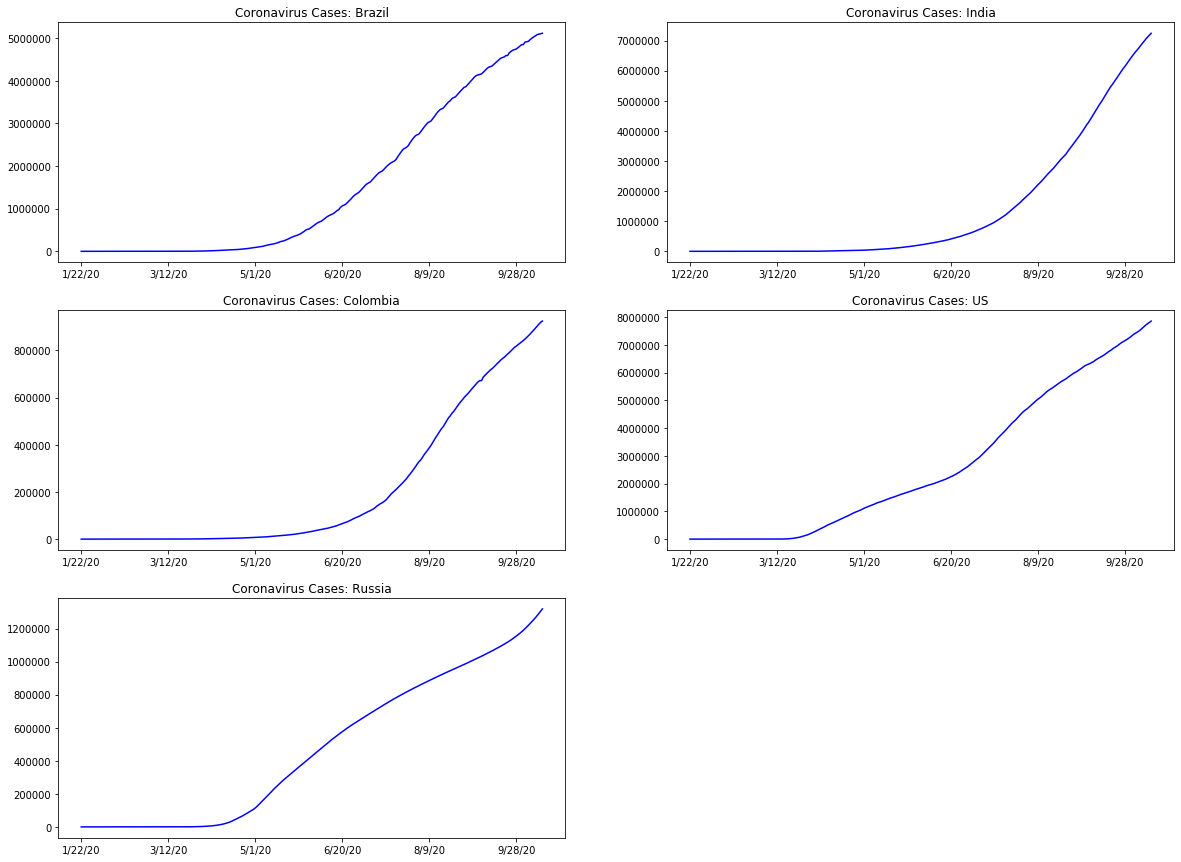

In [188]:
#countries = sorted(confirmed_df['Country/Region'].unique())
countries =["Brazil", "India", "Colombia", "US","Russia"]
n_rows = len(countries) // 2 + 1
i = 0
for country in (countries):
    country_data = confirmed_df[confirmed_df['Country/Region'] == country]
    # sum all the rows together for each column, and select only the data columns
    by_date = country_data.sum().filter(like='/20')
    
    # plot it if numbers exceed specified amount on date
    if by_date['10/10/20'] > 0:
        plt.subplot(n_rows, 2, i+1)
        by_date.plot(title='Coronavirus Cases: %s' % country, color='blue', figsize=(20,5 * n_rows))
        i += 1

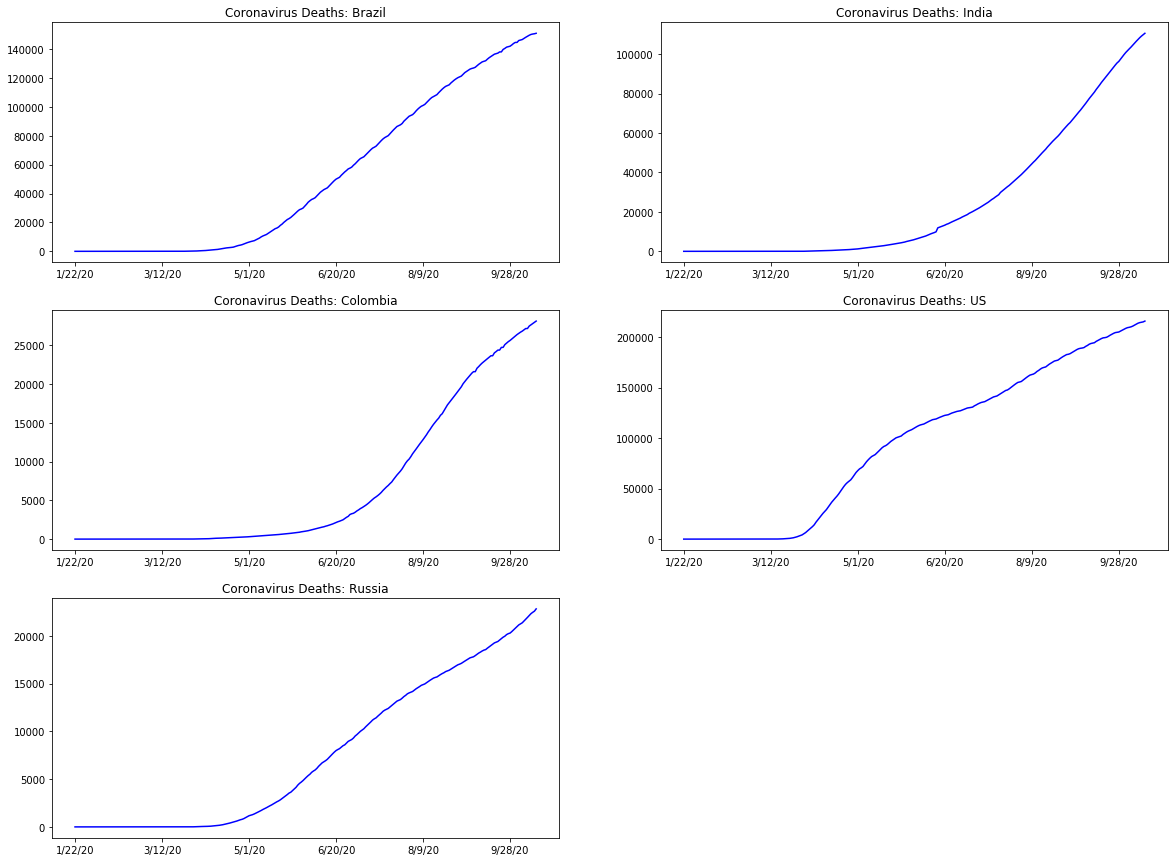

In [189]:
#countries = sorted(deaths_df['Country/Region'].unique())
countries =["Brazil", "India", "Colombia", "US","Russia"]
n_rows = len(countries) // 2 + 1
i = 0
for country in (countries):
    country_data = deaths_df[deaths_df['Country/Region'] == country]
    # sum all the rows together for each column, and select only the data columns
    by_date = country_data.sum().filter(like='/20')
    
    # plot it if numbers exceed specified amount on date
    if by_date['10/10/20'] > 0:
        plt.subplot(n_rows, 2, i+1)
        by_date.plot(title='Coronavirus Deaths: %s' % country, color='blue', figsize=(20,5 * n_rows))
        i += 1

# 2. Sorting the countries with most coronavirus cases
We first sort the data to understand the countries with most cases


In [190]:
date_list = confirmed_df.columns.tolist()[4:]
date_list[0], date_list[-1]

('1/22/20', '10/13/20')

In [191]:
# Confirmed cases per Country
confirmed_df[['Country/Region', date_list[-1]]].sort_values(by = date_list[-1], ascending = False).head(10)
# confirmed_df[['Country/Region', date_list[-1]]].sort_values(by = date_list[-1], ascending = True).head(5)

,Country/Region,10/13/20
243,US,7856605
143,India,7239389
30,Brazil,5113628
208,Russia,1318783
89,Colombia,924098
6,Argentina,917035
227,Spain,896086
202,Peru,853974
177,Mexico,825340
126,France,766421


In [80]:
#my_final_df[my_final_df['CountryCode'] == "USA"]
#my_final_df.describe
#my_final_df.columns
#my_final_df['Date'] 
#= pd.to_datetime(my_final_df['Date'], format='%Y%m%d')

#date_list= my_final_df.loc['2020-10-10']
#date_list
#my_final_df.set_index(my_final_df['Date'], inplace=True) 
#my_final_df[:,my_final_df["Date"]]
#confirmed_df[['Country/Region', date_list[-1]]].sort_values(by = date_list[-1], ascending = False).head(5)
#date_list[['CountryCode', "Confirmed"]].sort_values(by ="Confirmed", ascending = False).head(5)

In [81]:
my_final_df

,CountryCode,StringencyIndex,StringencyIndex_factor,Country_Region,Population,Confirmed,Deaths,Recovered,Active,New_cases,...,New_recovered,Confirmed_100K,Deaths_100K,Recovered_100K,Active_100K,New_cases_100K,New_deaths_100K,New_recovered_100K,GDP_in_USD,IncomeGroup
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,ABW,0.00,Very_low,Netherlands,106766.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,High income
2020-01-23,ABW,0.00,Very_low,Netherlands,106766.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,High income
2020-01-24,ABW,0.00,Very_low,Netherlands,106766.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,High income
2020-01-25,ABW,0.00,Very_low,Netherlands,106766.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,High income
2020-01-26,ABW,0.00,Very_low,Netherlands,106766.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,High income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-09,ZWE,76.85,High,Zimbabwe,14862927.0,7994.0,229.0,6474.0,1291.0,43.0,...,28.0,53.784830,1.540746,43.558042,8.686041,0.289310,0.000000,0.188388,2.144076e+10,Lower middle income
2020-10-10,ZWE,76.85,High,Zimbabwe,14862927.0,8010.0,230.0,6492.0,1288.0,16.0,...,18.0,53.892480,1.547474,43.679149,8.665857,0.107650,0.006728,0.121107,2.144076e+10,Lower middle income
2020-10-11,ZWE,76.85,High,Zimbabwe,14862927.0,8011.0,230.0,6504.0,1277.0,1.0,...,12.0,53.899208,1.547474,43.759887,8.591847,0.006728,0.000000,0.080738,2.144076e+10,Lower middle income


In [202]:
#Sorting by number of confirmed cases in 100K
#sort1 =my_final_df.groupby(['Date', "Country_Region"])[['Confirmed', 'Deaths', 'Recovered', 'StringencyIndex']].sum().reset_index()
#sort1
#sort1[sort1["Date"]=="2020-10-12"].sort_values(by = "Confirmed", ascending = True).head(50)
#sort2 = my_final_df.groupby(['Date', "Country_Region","IncomeGroup","GDP_in_USD"])[['Confirmed_100K', 'Deaths_100K', 'Recovered_100K']].sum().reset_index()
#sort2 = my_final_df.groupby(['Date', "Country_Region","incomeLevel.value","GDP_in_USD"])[['Confirmed_100K', 'Deaths_100K', 'Recovered_100K']].sum().reset_index()
# sort3=my_final_df.reset_index()
# sort3[sort3["Date"]=="2020-10-12"].sort_values(by = "Deaths_100K", ascending = False).head(20)
my_final_df.reset_index()[my_final_df.reset_index()['Date'] == "2020-10-12"].sort_values(by = "Deaths_100K", ascending = False).head(20)

,Date,CountryCode,StringencyIndex,StringencyIndex_factor,Country_Region,Population,Confirmed,Deaths,Recovered,Active,...,New_recovered,Confirmed_100K,Deaths_100K,Recovered_100K,Active_100K,New_cases_100K,New_deaths_100K,New_recovered_100K,GDP_in_USD,IncomeGroup
36174,2020-10-12,SMR,NaN,unknown,San Marino,33938.0,741.0,42.0,682.0,17.0,...,0.0,2183.393247,123.755083,2009.546821,50.091343,0.000000,0.000000,0.000000,NaN,High income
31386,2020-10-12,PER,NaN,unknown,Peru,32971846.0,851171.0,33357.0,743969.0,73845.0,...,5780.0,2581.508478,101.168130,2256.376546,223.963802,5.459203,0.157710,17.530107,2.268481e+11,Upper middle income
2924,2020-10-12,BEL,NaN,unknown,Belgium,11589616.0,165880.0,10211.0,20324.0,135345.0,...,52.0,1431.281243,88.104731,175.363877,1167.812635,31.252114,0.172568,0.448678,5.296067e+11,High income
1062,2020-10-12,AND,NaN,unknown,Andorra,77265.0,2995.0,57.0,1928.0,1010.0,...,114.0,3876.269980,73.772083,2495.308354,1307.189542,386.979874,2.588494,147.544166,3.154058e+09,High income
5318,2020-10-12,BOL,NaN,unknown,Bolivia,11673029.0,138695.0,8326.0,101523.0,28846.0,...,420.0,1188.166328,71.326817,869.722846,247.116665,1.036578,0.154202,3.598038,4.089532e+10,Lower middle income
5584,2020-10-12,BRA,NaN,unknown,Brazil,212559409.0,5103408.0,150689.0,4526393.0,426326.0,...,0.0,2400.932532,70.892651,2129.471954,200.567927,3.965480,0.094562,0.000000,1.839758e+12,Upper middle income
13298,2020-10-12,ESP,55.09,Middle,Spain,46754783.0,888968.0,33124.0,150376.0,705468.0,...,0.0,1901.341302,70.846228,321.626987,1508.868087,59.578931,0.417070,0.000000,1.394116e+12,High income
7446,2020-10-12,CHL,NaN,unknown,Chile,19116209.0,482832.0,13376.0,454434.0,15022.0,...,1082.0,2525.772762,69.972033,2377.218203,78.582526,7.642729,0.303407,5.660118,2.823182e+11,High income
12500,2020-10-12,ECU,NaN,unknown,Ecuador,17643060.0,147315.0,12218.0,128134.0,6963.0,...,0.0,834.974205,69.251026,726.257237,39.465943,1.598362,0.153035,0.000000,1.074357e+11,Upper middle income
26066,2020-10-12,MEX,NaN,unknown,Mexico,127792286.0,821045.0,83945.0,700826.0,36274.0,...,6612.0,642.484007,65.688628,548.410254,28.385125,2.771685,0.128333,5.174021,1.258287e+12,Upper middle income


In [83]:
#Sorting by number of deaths cases in 100K
sort1[sort1["Date"]=="2020-10-12"].sort_values(by = "Deaths", ascending = True).head(50)
sort2 = my_final_df.groupby(['Date', "Country_Region","incomeLevel.value","GDP_in_USD"])[['Confirmed_100K', 'Deaths_100K', 'Recovered_100K']].sum().reset_index()
sort2[sort2["Date"]=="2020-10-12"].sort_values(by = "Deaths_100K", ascending = False).head(20)

NameError: name 'sort1' is not defined

In [ ]:
# Sorting by stringency
#sort3 = my_final_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
#[sort3["StringencyIndex"].isna()]
#sort3.groupby(['Date', 'Country_Region'])[['StringencyIndex']].mean().reset_index()
#sort3
#sort3.sort_values(by = ["StringencyIndex", "Country_Region"], ascending = False).head(10)
#my_final_df[['Country_Region', "StringencyIndex"]].sort_values(by = ["StringencyIndex", "Country_Region"], ascending = False).head(10)

## Plotting the top ten MORE affected countries 


In [309]:
my_top = 10
top_deaths_100K = my_final_df['2020-10-13'].sort_values(by = "Deaths_100K", ascending = False).head(my_top).reset_index()['CountryCode'].to_list()#.set_index('CountryCode').to_dict()["Country_Region"]
top_confirmed_100K = my_final_df['2020-10-13'].sort_values(by = "Confirmed_100K", ascending = False).head(my_top).reset_index()['CountryCode'].to_list()#.set_index('CountryCode').to_dict()["Country_Region"]


In [310]:
top_deaths_100K_df = my_final_df[my_final_df['CountryCode'].isin(top_deaths_100K)].reset_index()
top_confirmed_100K_df = my_final_df[my_final_df['CountryCode'].isin(top_confirmed_100K)].reset_index()

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699.]),
 <a list of 9 Text xticklabel objects>)

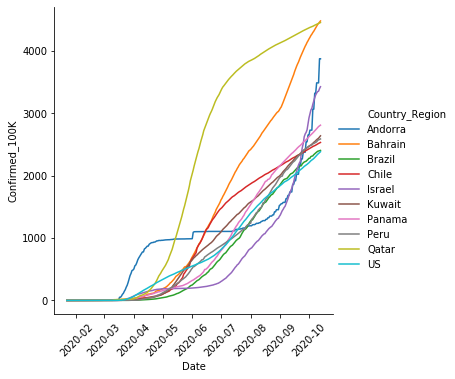

In [311]:
# Multiline Plot: number of confirmed cases in 100K 
confirmed_plot= sb.relplot(
    data=top_confirmed_100K_df, kind="line",
    x="Date", y="Confirmed_100K",
    hue="Country_Region")
plt.xticks(rotation=45) 
#plt.show()

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699.]),
 <a list of 9 Text xticklabel objects>)

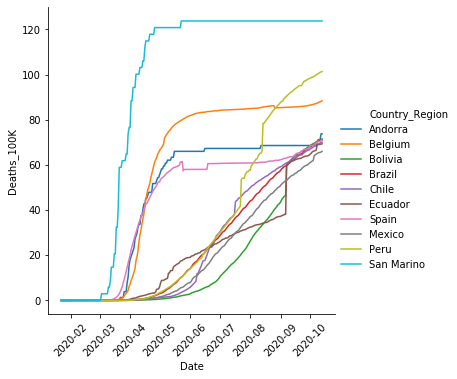

In [244]:
# Multiline Plot: number of confirmed cases in 100K 
confirmed_plot= sb.relplot(
    data=top_deaths_100K_df, kind="line",
    x="Date", y="Deaths_100K",
    hue="Country_Region")
plt.xticks(rotation=45) 
#plt.show()

## Plotting the top ten LESS affected countries 


In [253]:
my_top = 20
top_deaths_100K = my_final_df['2020-10-13'].sort_values(by = "Deaths_100K", ascending = True).head(my_top).reset_index()['CountryCode'].to_list()#.set_index('CountryCode').to_dict()["Country_Region"]
top_confirmed_100K = my_final_df['2020-10-13'].sort_values(by = "Confirmed_100K", ascending = True).head(my_top).reset_index()['CountryCode'].to_list()#.set_index('CountryCode').to_dict()["Country_Region"]


In [254]:
top_deaths_100K_df = my_final_df[my_final_df['CountryCode'].isin(top_deaths_100K)].reset_index()
top_confirmed_100K_df = my_final_df[my_final_df['CountryCode'].isin(top_confirmed_100K)].reset_index()

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699.]),
 <a list of 9 Text xticklabel objects>)

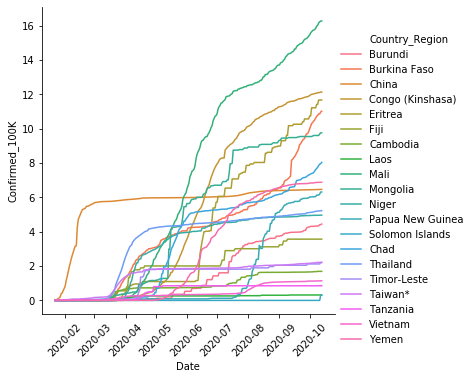

In [255]:
# Multiline Plot: number of confirmed cases in 100K 
confirmed_plot= sb.relplot(
    data=top_confirmed_100K_df, kind="line",
    x="Date", y="Confirmed_100K",
    hue="Country_Region")
plt.xticks(rotation=45) 
#plt.show()

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699.]),
 <a list of 9 Text xticklabel objects>)

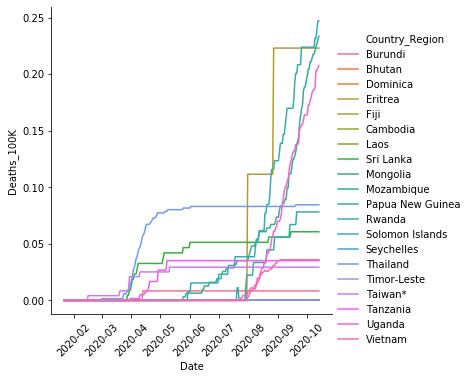

In [256]:
# Multiline Plot: number of confirmed cases in 100K 
confirmed_plot= sb.relplot(
    data=top_deaths_100K_df, kind="line",
    x="Date", y="Deaths_100K",
    hue="Country_Region")
plt.xticks(rotation=45) 
#plt.show()

## Filter High income countries and check what is the best stringency index

In [261]:
my_final_df.IncomeGroup.unique()

array(['Low income', 'Lower middle income', 'Upper middle income',
       'High income', nan], dtype=object)

In [291]:
best_10_confirmed=my_final_df[my_final_df['IncomeGroup'] == 'High income']["2020-10-13"].sort_values(by = "Confirmed_100K", ascending = True).head(10).reset_index()['CountryCode'].to_list()

In [279]:
best_10_deaths=my_final_df[my_final_df['IncomeGroup'] == 'High income']["2020-10-13"].sort_values(by = "Deaths_100K", ascending = True).head(10).reset_index()['CountryCode'].to_list()

In [280]:
best_10_confirmed

['MUS', 'BRN', 'NZL', 'KOR', 'URY', 'JPN', 'BRB', 'AUS', 'SYC', 'LVA']

In [282]:
best_deaths_100K_df = my_final_df[my_final_df['CountryCode'].isin(best_10_deaths)].reset_index()
best_confirmed_100K_df = my_final_df[my_final_df['CountryCode'].isin(best_10_confirmed)].reset_index()

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699.]),
 <a list of 9 Text xticklabel objects>)

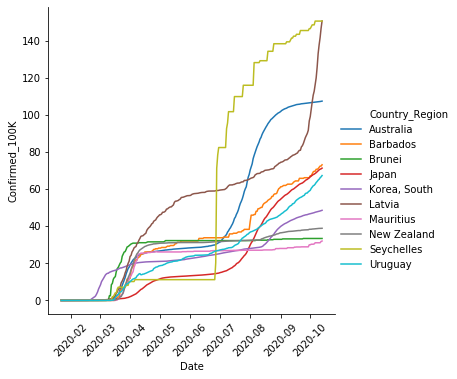

In [284]:
# Multiline Plot: number of confirmed cases in 100K 
confirmed_plot= sb.relplot(
    data=best_confirmed_100K_df, kind="line",
    x="Date", y="Confirmed_100K",
    hue="Country_Region")
plt.xticks(rotation=45) 
#plt.show()

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699.]),
 <a list of 9 Text xticklabel objects>)

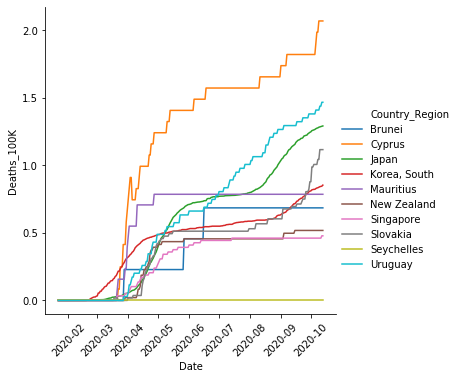

In [285]:
# Multiline Plot: number of confirmed cases in 100K 
confirmed_plot= sb.relplot(
    data=best_deaths_100K_df, kind="line",
    x="Date", y="Deaths_100K",
    hue="Country_Region")
plt.xticks(rotation=45) 
#plt.show()

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699.]),
 <a list of 9 Text xticklabel objects>)

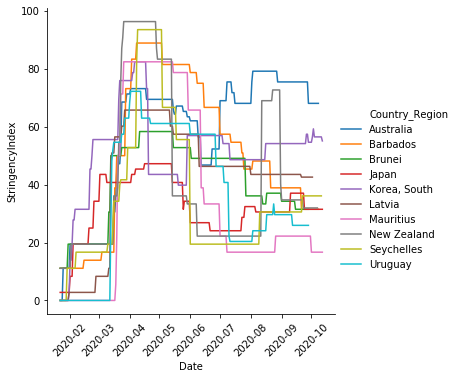

In [286]:
# Multiline Plot: number of confirmed cases in 100K 
confirmed_plot= sb.relplot(
    data=best_confirmed_100K_df, kind="line",
    x="Date", y="StringencyIndex",
    hue="Country_Region")
plt.xticks(rotation=45) 
#plt.show()

## Note: we remove countries with small population size (< 1000000 people)

In [297]:
best_10_confirmed=my_final_df[(my_final_df['IncomeGroup'] == 'High income') & (my_final_df['Population'] >= 1000000)]["2020-10-13"].sort_values(by = "Confirmed_100K", ascending = True).head(10).reset_index()['CountryCode'].to_list()

In [302]:
best_10_deaths=my_final_df[(my_final_df['IncomeGroup'] == 'High income')& (my_final_df['Population'] >= 1000000)]["2020-10-13"].sort_values(by = "Deaths_100K", ascending = True).head(10).reset_index()['CountryCode'].to_list()

In [303]:
best_10_confirmed

['MUS', 'NZL', 'KOR', 'URY', 'JPN', 'AUS', 'LVA', 'CYP', 'GRC', 'FIN']

In [304]:
best_deaths_100K_df = my_final_df[my_final_df['CountryCode'].isin(best_10_deaths)].reset_index()
best_confirmed_100K_df = my_final_df[my_final_df['CountryCode'].isin(best_10_confirmed)].reset_index()

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699.]),
 <a list of 9 Text xticklabel objects>)

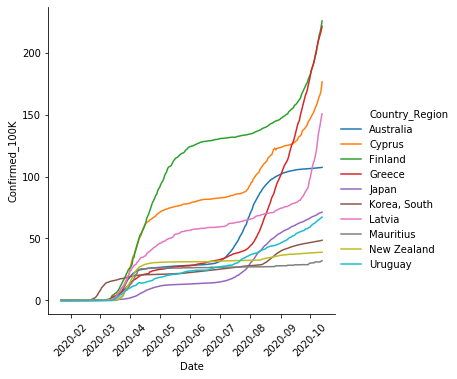

In [305]:
# Multiline Plot: number of confirmed cases in 100K 
confirmed_plot= sb.relplot(
    data=best_confirmed_100K_df, kind="line",
    x="Date", y="Confirmed_100K",
    hue="Country_Region")
plt.xticks(rotation=45) 
#plt.show()

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699.]),
 <a list of 9 Text xticklabel objects>)

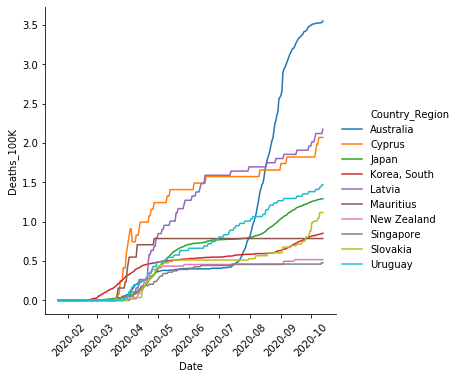

In [307]:
# Multiline Plot: number of confirmed cases in 100K 
confirmed_plot= sb.relplot(
    data=best_deaths_100K_df, kind="line",
    x="Date", y="Deaths_100K",
    hue="Country_Region")
plt.xticks(rotation=45) 
#plt.show()

(array([737456., 737485., 737516., 737546., 737577., 737607., 737638.,
        737669., 737699.]),
 <a list of 9 Text xticklabel objects>)

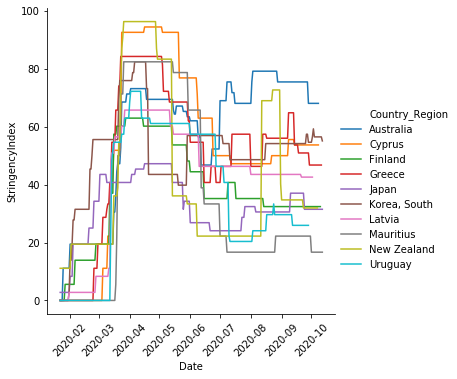

In [308]:
# Multiline Plot: number of confirmed cases in 100K 
confirmed_plot= sb.relplot(
    data=best_confirmed_100K_df, kind="line",
    x="Date", y="StringencyIndex",
    hue="Country_Region")
plt.xticks(rotation=45) 
#plt.show()

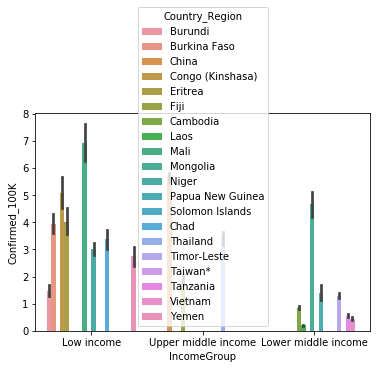

In [257]:
# Barplot Confirmed cases in 100K by income level
#filtered_coun= coun.loc[(coun['Confirmed'] != 0)]
sb.barplot(
    data=top_confirmed_100K_df, x="IncomeGroup", y="Confirmed_100K",
    hue="Country_Region")

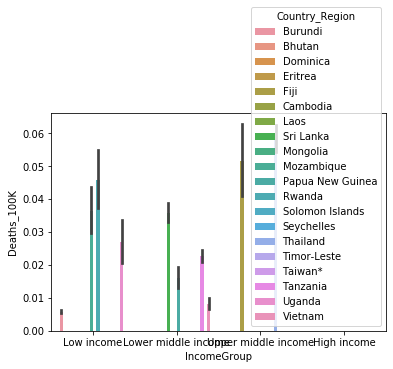

In [258]:
# Barplot Deaths in 100K by income level
#filtered_coun= coun.loc[(coun['Confirmed'] != 0)]
sb.barplot(
    data=top_deaths_100K_df, x="IncomeGroup", y="Deaths_100K",
    hue="Country_Region")

In [ ]:
my_final_df.columns

In [ ]:
sb.barplot(
    data=coun, x="StringencyIndex_factor", y="Confirmed_100K",
    hue="Country_Region")

In [245]:
top_deaths_100K_df

,Date,CountryCode,StringencyIndex,StringencyIndex_factor,Country_Region,Population,Confirmed,Deaths,Recovered,Active,...,New_recovered,Confirmed_100K,Deaths_100K,Recovered_100K,Active_100K,New_cases_100K,New_deaths_100K,New_recovered_100K,GDP_in_USD,IncomeGroup
0,2020-01-22,AND,0.0,Very_low,Andorra,77265.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,3.154058e+09,High income
1,2020-01-23,AND,0.0,Very_low,Andorra,77265.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,3.154058e+09,High income
2,2020-01-24,AND,0.0,Very_low,Andorra,77265.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,3.154058e+09,High income
3,2020-01-25,AND,0.0,Very_low,Andorra,77265.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,3.154058e+09,High income
4,2020-01-26,AND,0.0,Very_low,Andorra,77265.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,3.154058e+09,High income
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2655,2020-10-09,SMR,NaN,unknown,San Marino,33938.0,741.0,42.0,682.0,17.0,...,0.0,2183.393247,123.755083,2009.546821,50.091343,0.0,0.0,0.0,NaN,High income
2656,2020-10-10,SMR,NaN,unknown,San Marino,33938.0,741.0,42.0,682.0,17.0,...,0.0,2183.393247,123.755083,2009.546821,50.091343,0.0,0.0,0.0,NaN,High income
2657,2020-10-11,SMR,NaN,unknown,San Marino,33938.0,741.0,42.0,682.0,17.0,...,0.0,2183.393247,123.755083,2009.546821,50.091343,0.0,0.0,0.0,NaN,High income
2658,2020-10-12,SMR,NaN,unknown,San Marino,33938.0,741.0,42.0,682.0,17.0,...,0.0,2183.393247,123.755083,2009.546821,50.091343,0.0,0.0,0.0,NaN,High income


In [ ]:
# Individual Plots: number of confirmed cases in 100K 
my_final_df[my_final_df['CountryCode'] == "USA"].plot(y='Confirmed_100K', color='red',kind="line",c='c')
plt.ylim(0 , 1300)
plt.title("USA Confirmed 100K")
my_final_df[my_final_df['Country_Region'] == "India"].plot(y='Confirmed_100K',marker='', color='olive', linewidth=2)
plt.ylim(0 , 1300)
plt.title("India Confirmed 100K")
my_final_df[my_final_df['Country_Region'] == "Brazil"].plot(y='Confirmed_100K',kind="line",c='c')
plt.ylim(0 , 1300)
plt.title("Brazil Confirmed 100K")
my_final_df[my_final_df['Country_Region'] == "Russia"].plot(y='Confirmed_100K',kind="line",c='c')
plt.ylim(0 , 1300)
plt.title("Russia Confirmed 100K")
my_final_df[my_final_df['CountryCode'] == "COL"].plot(y='Confirmed_100K',kind="line",c='c')
plt.ylim(0 , 1300)
plt.title("Colombia Confirmed 100K")

plt.legend()
plt.show()


India_covid_df = my_final_df[my_final_df['Country_Region'] == "Brazil"]
plot1=India_covid_df.plot(y='Confirmed_100K',kind="line",c='c')
#plt.ylim(0 , 100)
plt.title("India confirmed cases")
plt.ylabel("Confirmed cases per 100K")
plt.show()


my_final_df[my_final_df['CountryCode'] == "USA"].plot(y='Confirmed_100K',kind="line",color='red',c='c')
plt.title("USA confirmed cases")
plt.ylabel("Confirmed cases per 100K")
plt.ylim(0 , 1300)
plt.legend()
plt.show()

my_final_df[my_final_df['Country_Region'] == "India"].plot(y='Confirmed_100K',marker='', color='olive', linewidth=2)
plt.title("India confirmed cases")
plt.ylabel("Confirmed cases per 100K")
plt.ylim(0 , 1300)
plt.legend()
plt.show()

my_final_df[my_final_df['Country_Region'] == "Brazil"].plot(y='Confirmed',kind="line",color='green',c='c')
plt.title("Brazil confirmed cases")
plt.ylabel("Confirmed cases per 100K")
#plt.ylim(0 , 1300)
plt.legend()
plt.show()
my_final_df[my_final_df['Country_Region'] == "Russia"].plot(y='Confirmed_100K',kind="line",c='c')
plt.title("Russia confirmed cases")
plt.ylabel("Confirmed cases per 100K")
plt.ylim(0 , 1300)
plt.legend()
plt.show()
my_final_df[my_final_df['CountryCode'] == "COL"].plot(y='Confirmed_100K',kind="line",color='purple',c='c')
plt.title("Colombia confirmed cases")
plt.ylabel("Confirmed cases per 100K")
plt.ylim(0 , 1300)
plt.legend()
plt.show()


India_covid_df = my_final_df[my_final_df['Country_Region'] == "Brazil"]
plot1=India_covid_df.plot(y='Confirmed_100K',kind="line",c='c')
#plt.ylim(0 , 100)
plt.title("India confirmed cases")
plt.ylabel("Confirmed cases per 100K")
plt.show()







In [ ]:
my_final_df[my_final_df['CountryCode'] == "USA"].plot(y='Deaths_100K',kind="line",c='c')
#plt.ylim(0 , 1300)
my_final_df[my_final_df['Country_Region'] == "India"].plot(y='Deaths_100K',marker='', color='olive', linewidth=2)
#plt.ylim(0 , 1300)
my_final_df[my_final_df['Country_Region'] == "Brazil"].plot(y='Deaths_100K',kind="line",c='c')
#plt.ylim(0 , 1300)
my_final_df[my_final_df['Country_Region'] == "Russia"].plot(y='Deaths_100K',kind="line",c='c')
#plt.ylim(0 , 1300)
my_final_df[my_final_df['CountryCode'] == "COL"].plot(y='Deaths_100K',kind="line",c='c')
#plt.ylim(0 , 1300)

plt.legend()
plt.show()


In [ ]:
my_final_df.describe()

#Stringency

In [ ]:
#A. USA Stringency 
my_complete_df[my_complete_df['CountryCode'] == "USA"].plot(y='StringencyIndex',color='red', kind="line",c='c')
#plt.plot( 'x', 'y3', data=df, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
plt.ylim(0 , 105)
plt.title("USA Stringency Index")
plt.ylabel("Stringency Index (%)")
plt.legend()
plt.show()



In [ ]:
#A. USA Stringency 
US_covid_df = my_complete_df[my_complete_df['CountryCode'] == "USA"]
#CHE_covid_df = my_complete_df[my_complete_df['Country_Region'] == "US"]
plot1=my_complete_df[my_complete_df['CountryCode'] == "USA"].plot(y='StringencyIndex',kind="line",c='c')
plt.show()
# B. India Stringency
India_covid_df = my_complete_df[my_complete_df['Country_Region'] == "India"]
#CHE_covid_df = my_complete_df[my_complete_df['Country_Region'] == "US"]
plot1=India_covid_df.plot(y='StringencyIndex',kind="line",c='c')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

#df=pd.DataFrame({'x': range(1,11), 'y1': np.random.randn(10), 'y2': np.random.randn(10)+range(1,11), 'y3': np.random.randn(10)+range(11,21) })

my_complete_df[my_complete_df['Country_Region'] == "India"].plot(y='StringencyIndex',marker='', color='olive', linewidth=2)
plt.ylim(0 , 105)
my_complete_df[my_complete_df['CountryCode'] == "USA"].plot(y='StringencyIndex',kind="line",c='c')
plt.ylim(0 , 105)
my_complete_df[my_complete_df['Country_Region'] == "Brazil"].plot(y='StringencyIndex')
plt.ylim(0 , 105)

# C. Brazil Stringency
Bra_covid_df = my_complete_df[my_complete_df['Country_Region'] == "Brazil"]
#CHE_covid_df = my_complete_df[my_complete_df['Country_Region'] == "US"]
plot1=Bra_covid_df.plot(y='StringencyIndex',kind="line",c='c')
plt.show()

plt.legend()
plt.show()

my_complete_df[my_complete_df['Country_Region'] == "Brazil"].plot(y='StringencyIndex', color='green')
plt.title("Brazil Stringency Index")
plt.ylim(0 , 105)
plt.ylabel("Stringency Index (%)")
plt.legend()
plt.show()


In [ ]:
my_final_df

#3. Correlations

Here, we explored the correlations between the variables



In [ ]:
#coun[coun["Confirmed"] = 1]
#coun[coun["Confirmed"]]
coun.isna().sum()

In [ ]:
# We explored the graphical correlation between the variables of interest

#col_stringe=stringe_natio_dataset[stringe_natio_dataset["CountryName"]=="Colombia"]
#col_stringe
#stringe_natio_dataset['Date'] = pd.to_datetime(stringe_natio_dataset['Date'], format = '%Y%m%d')
col_sub= my_final_df[my_final_df['Country_Region'] == "Colombia"]
ind_sub= my_final_df[my_final_df['Country_Region'] == "India"]
usa_sub= my_final_df[my_final_df['CountryCode'] == "USA"]
bra_sub = my_final_df[my_final_df['Country_Region'] == "Brazil"]
rus_sub= my_final_df[my_final_df['Country_Region'] == "Russia"]


In [ ]:
col_sub =col_sub[["Confirmed_100K", "StringencyIndex","Deaths_100K", "Recovered"]]
ind_sub =ind_sub[["Confirmed_100K", "StringencyIndex","Deaths_100K", "Recovered"]]
usa_sub =usa_sub[["Confirmed_100K", "StringencyIndex","Deaths_100K", "Recovered"]]
bra_sub =bra_sub[["Confirmed_100K", "StringencyIndex","Deaths_100K", "Recovered"]]
rus_sub =rus_sub[["Confirmed_100K", "StringencyIndex","Deaths_100K", "Recovered"]]

sb.pairplot(col_sub)
sb.pairplot(ind_sub)
sb.pairplot(usa_sub)
sb.pairplot(bra_sub)
sb.pairplot(rus_sub)
#col_sub["Confirmed_100K"]

In [ ]:
#spearmanr_coefficient, p_value=spearmanr(col_sub["Confirmed_100K"],col_sub["Deaths_100K"])
p_value1=spearmanr(col_sub["Confirmed_100K"],col_sub["Deaths_100K"])
p_value2=spearmanr(col_sub["Confirmed_100K"],col_sub["Recovered"])
p_value3=spearmanr(col_sub["Confirmed_100K"],col_sub["StringencyIndex"])
p_value3
#spearmanr_coefficient

In [ ]:

#training_set_deaths = my_col_death
y_deaths = np.array([my_col_death["StringencyIndex"]]).reshape(-1, 1)
x_deaths = np.array([my_col_death["Deaths"]]).reshape(-1, 1)
#len(y_deaths)
pearsonr(x_deaths, y_deaths)
len(y_deaths)

# 4. Polynomial Regression of Coronavirus cases

This data could be potentially used for predictive analysis


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

class PolynomialRegressionModel:

    def __init__(self, model_name, polynomial_degree):
        self.__model_name = model_name
        self.__polynomial_degree = polynomial_degree
        self.__model = None

    def train(self, x, y):
        polynomial_features = PolynomialFeatures(degree=self.__polynomial_degree)
        x_poly = polynomial_features.fit_transform(x)
        self.__model = LinearRegression()
        self.__model.fit(x_poly, y)

    def get_predictions(self, x):
        polynomial_features = PolynomialFeatures(degree=self.__polynomial_degree)
        x_poly = polynomial_features.fit_transform(x)
        return np.round(self.__model.predict(x_poly), 0).astype(np.int32)

    def get_model_polynomial_str(self):
        coef = self.__model.coef_
        intercept = self.__model.intercept_
        poly = "{0:.3f}".format(intercept)

        for i in range(1, len(coef)):
            if coef[i] >= 0:
                poly += " + "
            else:
                poly += " - "
            poly += "{0:.3f}".format(coef[i]).replace("-", "") + "X^" + str(i)

        return poly

In [ ]:
def print_forecast(model_name, model, beginning_day=0, limit=10):

    next_days_x = np.array(range(beginning_day, beginning_day + limit)).reshape(-1, 1)
    next_days_pred = model.get_predictions(next_days_x)

    print("The forecast for " + model_name + " in the following " + str(limit) + " days is:")
    for i in range(0, limit):
        print("Day " + str(i + 1) + ": " + str(next_days_pred[i]))

In [ ]:
import operator

def plot_graph(model_name, x, y, y_pred):

    plt.scatter(x, y, s=10)
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x, y_pred), key=sort_axis)
    x, y_pred = zip(*sorted_zip)

    plt.plot(x, y_pred, color='m')
    plt.title("Amount of " + model_name + " in each day")
    plt.xlabel("Day")
    plt.ylabel(model_name)
    plt.show()

In [ ]:
# 1. Data, first example is Russia
overall_deaths_ts_df = deaths_df[deaths_df["Country/Region"] == "Colombia"]
new_country_deaths_df = overall_deaths_ts_df[date_list].T


new_country_deaths_df.columns = ["deaths"]
new_country_deaths_df = new_country_deaths_df.assign(days=[1 +
                                                   i for i in range(len(new_country_deaths_df))])[['days'] + 
                                                   new_country_deaths_df.columns.tolist()]
new_country_deaths_df

In [ ]:
overall_deaths_ts_df = confirmed_df[confirmed_df["Country/Region"] == "India"]
new_country_deaths_df = overall_deaths_ts_df[date_list].T


new_country_deaths_df.columns = ["confirmed"]
new_country_deaths_df = new_country_deaths_df.assign(days=[1 +
                                                   i for i in range(len(new_country_deaths_df))])[['days'] + 
                                                   new_country_deaths_df.columns.tolist()]
new_country_deaths_df

In [ ]:
# 2. select data attention
training_set_deaths = new_country_deaths_df
x_deaths = np.array(training_set_deaths["days"]).reshape(-1, 1)
y_deaths = training_set_deaths["confirmed"]

In [ ]:
# 3 Modelling Country predictive deaths
regression_model = PolynomialRegressionModel("Deaths using Polynomial Regression", 2)
regression_model.train(x_deaths, y_deaths)
y_deaths_pred = regression_model.get_predictions(x_deaths)
print_forecast("Deaths using Polynomial Regression", regression_model, 
               beginning_day=len(x_deaths), 
               limit=10)
plot_graph("Russia Deaths", x_deaths, y_deaths, y_deaths_pred)

# Examples


In [ ]:
dates = confirmed_df.columns[4:]

confirmed_df_long = confirmed_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Confirmed')

deaths_df_long = deaths_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Deaths')

recovered_df_long = recovered_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Recovered')

In [ ]:
# World Recovered
world_recovered_ts_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
world_recovered_ts_df = pd.read_csv(world_recovered_ts_url, header=0, escapechar='\\')
world_recovered_ts_df.head(5)

In [ ]:
world_recovered_ts_df = world_recovered_ts_df.assign(days=[1 + 
                                               i for i in range(len(world_recovered_ts_df))])[['days'] + 
                                               world_recovered_ts_df.columns.tolist()]

In [ ]:
recovered_df_long = world_recovered_ts_df.melt(
    id_vars=["days",'Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Recovered')

In [ ]:
training_set = recovered_df_long
x = np.array(training_set["days"]).reshape(-1, 1)
y = training_set["Recovered"]

In [ ]:
regression_model = PolynomialRegressionModel("Cases using Polynomial Regression", 2)
regression_model.train(x, y)

In [ ]:
y_pred = regression_model.get_predictions(x)
y_pred
training_set = new_usa_recovered_df
x = np.array(training_set["days"]).reshape(-1, 1)
y = training_set["recovered"]

In [ ]:
#world_confirmed_ts_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

In [ ]:
confirmed_df_india = confirmed_df[confirmed_df["Country/Region"]=="India"]
deaths_df_india = deaths_df[deaths_df["Country/Region"]=="India"]
recovered_df_india= recovered_df[recovered_df["Country/Region"]=="India"]
recovered_df_india
#deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
#recovered_df = pd.read_csv('time_series_covid19_recovered_global.csv')

In [ ]:
# 1. Data, first example is Russia 2
new_country_deaths_df= my_final_df[my_final_df['Country_Region'] == "Colombia"]
#overall_deaths_ts_df = deaths_df[deaths_df["Country/Region"] == "Russia"]
#new_country_deaths_df = overall_deaths_ts_df[date_list].T
#new_country_deaths_df.columns = ["deaths"]
new_country_deaths_df = new_country_deaths_df.assign(days=[1 +
                                                   i for i in range(len(new_country_deaths_df))])[['days'] + 
                                                   new_country_deaths_df.columns.tolist()]
new_country_deaths_df

In [ ]:
# 2. select data attention
training_set_deaths = new_country_deaths_df
x_deaths = np.array(training_set_deaths["days"]).reshape(-1, 1)
y_deaths = training_set_deaths["Deaths"]
x_active = np.array(training_set_deaths["days"]).reshape(-1, 1)
y_active = training_set_deaths["Active"]
x_confirmed = np.array(training_set_deaths["days"]).reshape(-1, 1)
y_confirmed = training_set_deaths["Confirmed"]


In [ ]:
# 3 Modelling Country predictive deaths, 
regression_model = PolynomialRegressionModel("Deaths using Polynomial Regression", 2)
regression_model.train(x_deaths, y_deaths)
y_deaths_pred = regression_model.get_predictions(x_deaths)
print_forecast("Deaths using Polynomial Regression", regression_model, 
               beginning_day=len(x_deaths), 
               limit=10)
plot_graph("Colombia Deaths", x_deaths, y_deaths, y_deaths_pred)

regression_model = PolynomialRegressionModel("Deaths using Polynomial Regression", 3)
regression_model.train(x_active, y_active)
y_active_pred = regression_model.get_predictions(x_active)
print_forecast("Deaths using Polynomial Regression", regression_model, 
               beginning_day=len(x_active), 
               limit=10)
plot_graph("Colombia Active", x_active, y_active, y_active_pred)

regression_model = PolynomialRegressionModel("Deaths using Polynomial Regression", 2)
regression_model.train(x_confirmed, y_confirmed)
y_confirmed_pred = regression_model.get_predictions(x_confirmed)
print_forecast("Deaths using Polynomial Regression", regression_model, 
               beginning_day=len(x_confirmed), 
               limit=10)
plot_graph("Colombia Confirmed", x_confirmed, y_confirmed, y_confirmed_pred)

# More Code

In [ ]:
import operator

def plot_graph(model_name, x, y, y_pred):

    plt.scatter(x, y, s=10)
    sort_axis = operator.itemgetter(0)
    sorted_zip = sorted(zip(x, y_pred), key=sort_axis)
    x, y_pred = zip(*sorted_zip)

    plt.plot(x, y_pred, color='m')
    plt.title("Amount of " + model_name + " in each day")
    plt.xlabel("Day")
    plt.ylabel(model_name)
    plt.show()

In [ ]:
sb.boxplot(
    data=coun, x="incomeLevel.value", y="Confirmed",
    hue="Country_Region")

#my_complete_df[my_complete_df['CountryCode'] == "USA"]
#CHE_covid_df = my_complete_df[my_complete_df['Country_Region'] == "US"]

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
Bra_covid_df.plot(y='StringencyIndex',kind="line",c='c')

#ax1.plot(x, y1, 'g-')
#ax2.plot(x, y2, 'b-')

In [ ]:
countries = ["US", "India", "Brazil", "Russia", "Colombia"]
my_final_df[my_final_df['Country_Region'].isin(countries)].plot(y='Confirmed_100K',kind="line",c='c')

df=pd.DataFrame({'y1': my_final_df[my_final_df['Country_Region'] == "Brazil",],
                 'y2': np.random.randn(10)+range(1,11), 
                 'y3': np.random.randn(10)+range(11,21) })

# multiple line plot
#plt.plot( 'x', 'y1', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
#plt.plot( 'x', 'y2', data=df, marker='', color='olive', linewidth=2)
#plt.plot( 'x', 'y3', data=df, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")



In [ ]:
usa_overall_deaths_ts_df = world_deaths_ts_df[world_deaths_ts_df["Country/Region"] == "Russia"]
new_usa_deaths_df = usa_overall_deaths_ts_df[date_list].T
new_usa_deaths_df.columns = ["deaths"]
new_usa_deaths_df = new_usa_deaths_df.assign(days=[1 +
                                                   i for i in range(len(new_usa_deaths_df))])[['days'] + 
                                                   new_usa_deaths_df.columns.tolist()]
new_usa_deaths_df

In [ ]:
x_deaths

In [ ]:
y_pred = regression_model.get_predictions(x)
y_pred

In [ ]:
print_forecast("Cases using Polynomial Regression", regression_model, 
               beginning_day=len(x), 
               limit=10)

In [ ]:
plot_graph("Cases using Polynomial Regression", x, y, y_pred)


In [ ]:
# Model
regression_model = PolynomialRegressionModel("Cases using Polynomial Regression", 2)
regression_model.train(x_deaths, y_deaths)

In [ ]:
# For Colombia
deaths_df
overall_deaths_ts_df = deaths_df[deaths_df["Country/Region"] == "Colombia"]
new_country_deaths_df = overall_deaths_ts_df[date_list].T
new_country_deaths_df.columns = ["deaths"]
new_country_deaths_df = new_country_deaths_df.assign(days=[1 +
                                                   i for i in range(len(new_country_deaths_df))])[['days'] + 
                                                   new_country_deaths_df.columns.tolist()]
new_country_deaths_df

In [ ]:
#countries = sorted(corona_data['Country/Region'].unique())
countries =["Brazil", "India"]
n_rows = len(countries) // 2 + 1
i = 0
for country in (countries):
    country_data = my_final_df[my_final_df['Country_Region'] == country]
    # sum all the rows together for each column, and select only the data columns
    by_date = country_data[my_final_df['Confirmed_100K'].filter(like='/20')

#my_final_df[my_final_df['Country_Region'] == "Russia"].plot(y='Confirmed_100K',kind="line",c='c')
    # plot it if numbers exceed specified amount on date
    if by_date['3/14/20'] > 1000:
        plt.subplot(n_rows, 2, i+1)
        by_date.plot(title='cases by date: %s' % country, color='green', figsize=(20,5 * n_rows))
        i += 1